# Anxiety Level Classification Using LVQ and Wearable Data

## Import Libraries

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

## Load Dataset

In [14]:
df = pd.read_csv("Stress-Lysis.csv")
df.head()

,Humidity,Temperature,Step count,Stress Level
0,21.33,90.33,123,1
1,21.41,90.41,93,1
2,27.12,96.12,196,2
3,27.64,96.64,177,2
4,10.87,79.87,87,0


## LVQ Class

In [15]:
class LVQ:
    def __init__(self):
        self.weights = np.array([])
        self.labels = np.array([])

    def train(self, training_data, target_labels, learning_rate, decay_factor, max_epochs):
        unique_labels, initial_indices = np.unique(target_labels, return_index=True)
        self.labels = unique_labels
        self.weights = training_data[initial_indices].astype(np.float64)
        training_data = np.delete(training_data, initial_indices, axis=0)
        target_labels = np.delete(target_labels, initial_indices, axis=0)

        epoch = 0
        while epoch < max_epochs:
            for i, sample in enumerate(training_data):
                distances = [np.sum((weight - sample) ** 2) for weight in self.weights]
                closest_index = np.argmin(distances)
                adjustment_sign = 1 if target_labels[i] == self.labels[closest_index] else -1
                self.weights[closest_index] += adjustment_sign * learning_rate * (sample - self.weights[closest_index])
            learning_rate *= decay_factor
            epoch += 1

    def predict(self, input_data):
        predictions = []
        for sample in input_data:
            distances = [np.sum((weight - sample) ** 2) for weight in self.weights]
            predictions.append(self.labels[np.argmin(distances)])
        return np.array(predictions)

def calculate_accuracy(predicted_labels, true_labels):
    correct_predictions = [1 if predicted_labels[i] == true_labels[i] else 0 for i in range(len(predicted_labels))]
    return sum(correct_predictions) / len(predicted_labels)

## Preprocessing

In [16]:
scaler = MinMaxScaler()
features = df[['Humidity', 'Temperature', 'Step count']]
scaled_features = scaler.fit_transform(features)

encoder = LabelEncoder()
target = encoder.fit_transform(df['Stress Level'])

X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2, random_state=42)

## Correlation and Scatter Plot

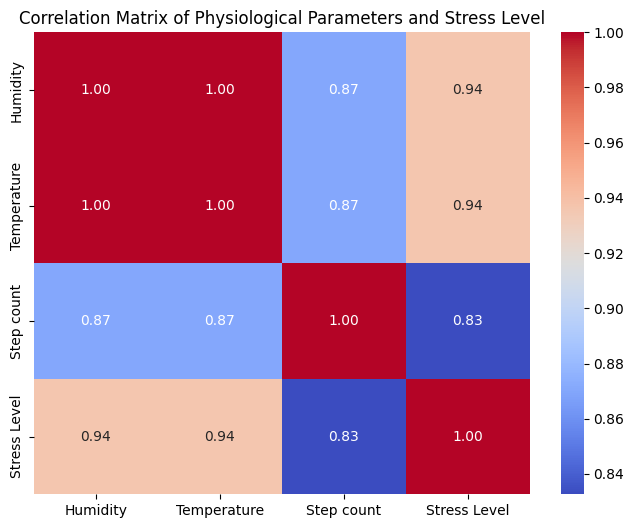

Parameter fisiologis yang paling berpengaruh: Humidity


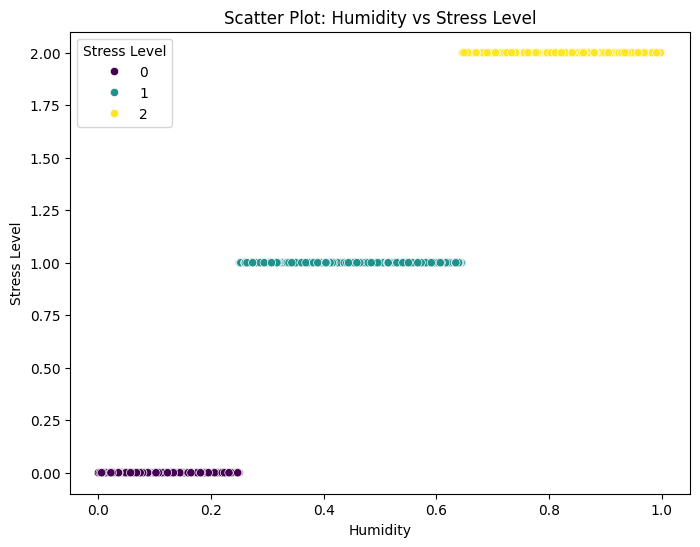

In [17]:
scaled_df = pd.DataFrame(scaled_features, columns=['Humidity', 'Temperature', 'Step count'])
scaled_df['Stress Level'] = target

correlation_matrix = scaled_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Physiological Parameters and Stress Level")
plt.show()

stress_correlation = correlation_matrix['Stress Level'].drop('Stress Level')
most_influential_parameter = stress_correlation.abs().idxmax()
print(f"Parameter fisiologis yang paling berpengaruh: {most_influential_parameter}")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=scaled_df, x=most_influential_parameter, y='Stress Level', hue='Stress Level', palette='viridis')
plt.title(f"Scatter Plot: {most_influential_parameter} vs Stress Level")
plt.xlabel(most_influential_parameter)
plt.ylabel("Stress Level")
plt.legend(title='Stress Level')
plt.show()

## Training Data Size vs Accuracy

Training Size vs Accuracy: {10: np.float64(0.9625935162094763), 20: np.float64(0.9625935162094763), 40: np.float64(0.9625935162094763), 60: np.float64(0.9650872817955112), 80: np.float64(0.9650872817955112)}


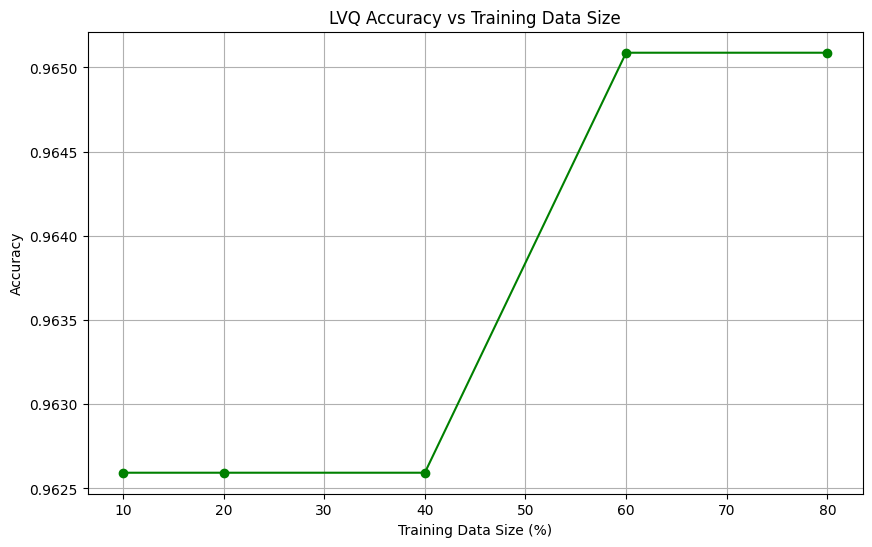

In [18]:
training_sizes = [10, 20, 40, 60, 80]
accuracies_by_size = {}

for size in training_sizes:
    trial_accuracies = []
    for _ in range(5):
        X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2, train_size=size/100, random_state=42)
        lvq = LVQ()
        lvq.train(X_train, y_train, learning_rate=0.3, decay_factor=0.8, max_epochs=100)
        predictions = lvq.predict(X_test)
        accuracy = calculate_accuracy(predictions, y_test)
        trial_accuracies.append(accuracy)
    accuracies_by_size[size] = np.mean(trial_accuracies)

print(f"Training Size vs Accuracy: {accuracies_by_size}")

plt.figure(figsize=(10, 6))
plt.plot(training_sizes, list(accuracies_by_size.values()), marker='o', linestyle='-', color='g')
plt.title('LVQ Accuracy vs Training Data Size')
plt.xlabel('Training Data Size (%)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

## Decay Factor vs Accuracy

Accuracy for different decay factors: [0.9650872817955112, 0.9650872817955112, 0.9650872817955112, 0.9650872817955112, 0.9650872817955112, 0.9650872817955112, 0.9650872817955112, 0.9650872817955112, 0.9650872817955112, 0.9052369077306733]


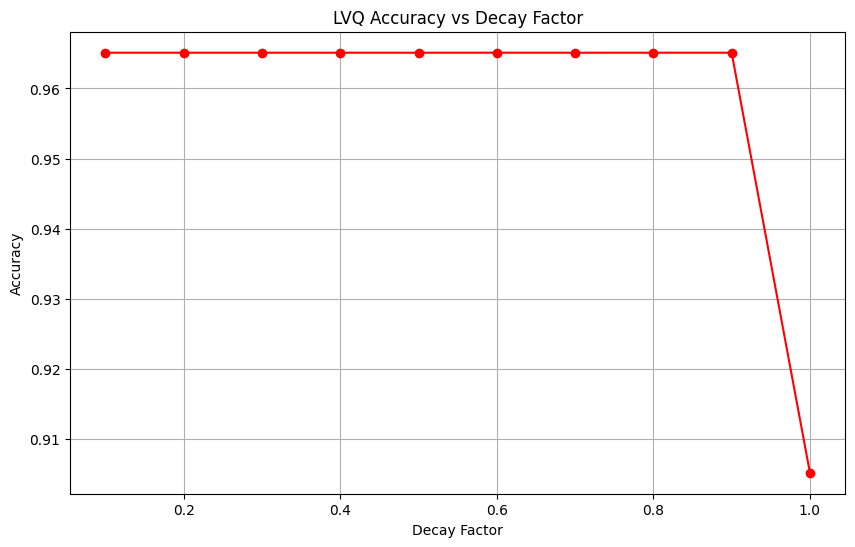

In [19]:
decay_factors = [0.1 * i for i in range(1, 11)]
learning_rate = 0.3
max_epochs = 100
decay_accuracies = []

for decay in decay_factors:
    lvq = LVQ()
    lvq.train(X_train, y_train, learning_rate=learning_rate, decay_factor=decay, max_epochs=max_epochs)
    predictions = lvq.predict(X_test)
    accuracy = calculate_accuracy(predictions, y_test)
    decay_accuracies.append(accuracy)

print(f"Accuracy for different decay factors: {decay_accuracies}")

plt.figure(figsize=(10, 6))
plt.plot(decay_factors, decay_accuracies, marker='o', linestyle='-', color='r')
plt.title('LVQ Accuracy vs Decay Factor')
plt.xlabel('Decay Factor')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

## Learning Rate vs Accuracy

Accuracy: [0.9650872817955112, 0.9650872817955112, 0.9650872817955112, 0.9650872817955112, 0.9650872817955112, 0.9650872817955112, 0.9650872817955112, 0.23690773067331672, 0.23690773067331672, 0.3640897755610973]


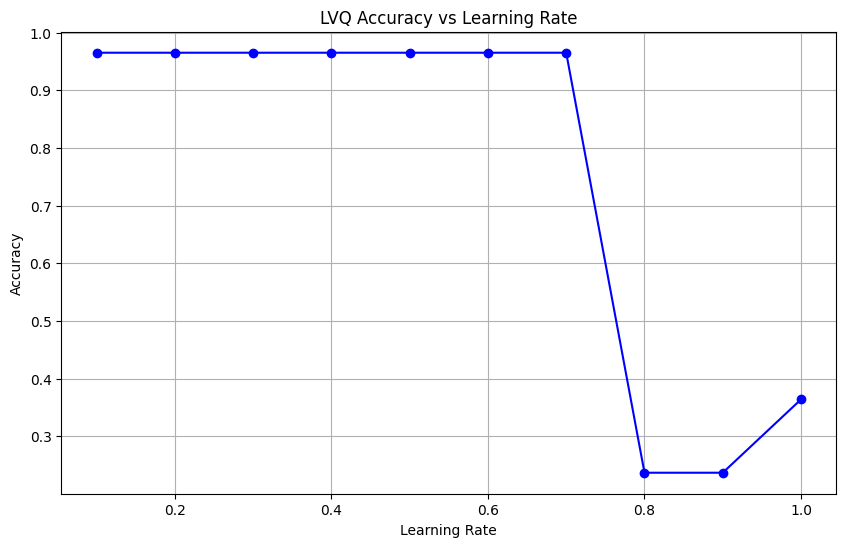

In [20]:
learning_rates = [0.1 * i for i in range(1, 11)]
decay_factor = 0.8
accuracies = []

for lr in learning_rates:
    lvq = LVQ()
    lvq.train(X_train, y_train, learning_rate=lr, decay_factor=decay_factor, max_epochs=max_epochs)
    predictions = lvq.predict(X_test)
    accuracy = calculate_accuracy(predictions, y_test)
    accuracies.append(accuracy)

print(f"Accuracy: {accuracies}")

plt.figure(figsize=(10, 6))
plt.plot(learning_rates, accuracies, marker='o', linestyle='-', color='b')
plt.title('LVQ Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

## Cross Validation

In [21]:
num_samples = len(df)
part_size = num_samples // 3
indices = np.arange(num_samples)
np.random.seed(42)
np.random.shuffle(indices)

part1_indices = indices[:part_size]
part2_indices = indices[part_size:2 * part_size]
part3_indices = indices[2 * part_size:]
parts = [part1_indices, part2_indices, part3_indices]

learning_rate = 0.3
decay_factor = 0.6
max_epochs = 100

print("No\tData Latih\tData Uji\tAkurasi")
for i, test_indices in enumerate(parts):
    train_indices = np.hstack([parts[j] for j in range(3) if j != i])
    X_train, y_train = scaled_features[train_indices], target[train_indices]
    X_test, y_test = scaled_features[test_indices], target[test_indices]
    lvq = LVQ()
    lvq.train(X_train, y_train, learning_rate, decay_factor, max_epochs)
    predictions = lvq.predict(X_test)
    accuracy = calculate_accuracy(predictions, y_test)
    train_parts = ["K" + str(j + 1) for j in range(3) if j != i]
    test_part = "K" + str(i + 1)
    print(f"{i + 1}\t{', '.join(train_parts)}\t{test_part}\t{accuracy:.5f}")

No	Data Latih	Data Uji	Akurasi
1	K2, K3	K1	0.96402
2	K1, K3	K2	0.92654
3	K1, K2	K3	0.94603


## Final Classification Visualization

LVQ Accuracy: 0.9460269865067467


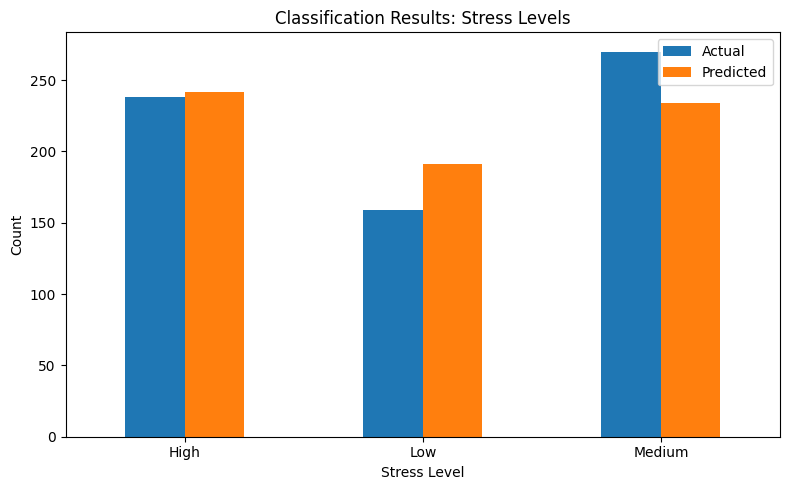

In [22]:
lvq = LVQ()
lvq.train(X_train, y_train, learning_rate, decay_factor, max_epochs)
lvq_predictions = lvq.predict(X_test)
lvq_accuracy = calculate_accuracy(lvq_predictions, y_test)
print(f"LVQ Accuracy: {lvq_accuracy}")

unique_levels = ['Low', 'Medium', 'High']
y_test_labels = [unique_levels[label] for label in y_test]
lvq_pred_labels = [unique_levels[label] for label in lvq_predictions]

actual_counts = pd.Series(y_test_labels).value_counts()
predicted_counts = pd.Series(lvq_pred_labels).value_counts()

comparison_df = pd.DataFrame({'Actual': actual_counts, 'Predicted': predicted_counts}).fillna(0)
comparison_df.plot(kind='bar', figsize=(8, 5))
plt.title('Classification Results: Stress Levels')
plt.xlabel('Stress Level')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()